# Import Libraries

In [122]:
import os
import cv2
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

from PIL import Image
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [4]:
images_path = "/kaggle/input/face-mask-detection/images"
annotations_path = "/kaggle/input/face-mask-detection/annotations"

In [5]:
class FaceMaskDataset(Dataset):
    def __init__(self, images_path, annotations_path):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.images = os.listdir(images_path)

    def __getitem__(self, idx):
        image = transforms.ToTensor()(Image.open(os.path.join(self.images_path, self.images[idx])).convert("RGB"))

        annotation_path = os.path.join(self.annotations_path, self.images[idx][:-3] + "xml")
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        bbox = [[int(box.find(f"bndbox/{i}").text) for i in ["xmin", "ymin", "xmax", "ymax"]] for box in root.iter("object")]
        labels = [2 if box.find("name").text == "with_mask" else 1 for box in root.iter("object")]

        bbox = torch.tensor(bbox, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": bbox,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (bbox[:, 2] - bbox[:, 0]) * (bbox[:, 3] - bbox[:, 1]),
            "iscrowd": torch.zeros(len(bbox), dtype=torch.int64)
        }

        return image, target

    def __len__(self):
        return len(self.images)


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
dataset = FaceMaskDataset(images_path, annotations_path)

In [125]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [126]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Faster R-CNN

In [141]:
model = fasterrcnn_resnet50_fpn(weights=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model = model.to(device)

# Train

In [148]:
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=0.0001)
# optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.001, momentum=0.95, weight_decay=0.05)

In [149]:
epochs = 10

In [150]:
losses = []

In [17]:
import wandb
from kaggle_secrets import UserSecretsClient

wandb.login(key=UserSecretsClient().get_secret("wandb_key"))

wandb: Currently logged in as: letim (letim-hse). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# wandb.finish()

In [152]:
wandb.init(project='face_mask_detection', name='faster_rcnn')

In [153]:
for epoch in range(epochs):
    curr_loss = 0.0
    model.train()
    start_time = time.time()

    for images, targets in tqdm(train_dataloader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        optimizer.zero_grad()

        outputs = model(images, targets)
        loss = sum(loss for loss in outputs.values())
        loss.backward()
        
        optimizer.step()

        curr_loss += loss.item()

    end_time = time.time()
    epoch_time = end_time - start_time
    avg_loss = curr_loss / len(train_dataloader)
    losses.append(avg_loss)
    wandb.log({'train_loss': avg_loss})
    print(f"Epoch [{epoch+1}/{epochs}], [Loss: {avg_loss:.4f}], [Time: {epoch_time:.2f}s]")

wandb.finish()

100%|██████████| 341/341 [03:52<00:00,  1.47it/s]


Epoch [1/10], [Loss: 0.3930], [Time: 232.58s]


100%|██████████| 341/341 [03:49<00:00,  1.49it/s]


Epoch [2/10], [Loss: 0.2878], [Time: 229.26s]


100%|██████████| 341/341 [03:47<00:00,  1.50it/s]


Epoch [3/10], [Loss: 0.2432], [Time: 227.54s]


100%|██████████| 341/341 [03:51<00:00,  1.48it/s]


Epoch [4/10], [Loss: 0.2010], [Time: 231.18s]


100%|██████████| 341/341 [03:51<00:00,  1.47it/s]


Epoch [5/10], [Loss: 0.1854], [Time: 231.38s]


100%|██████████| 341/341 [03:51<00:00,  1.47it/s]


Epoch [6/10], [Loss: 0.1621], [Time: 231.32s]


100%|██████████| 341/341 [03:47<00:00,  1.50it/s]


Epoch [7/10], [Loss: 0.1551], [Time: 227.11s]


100%|██████████| 341/341 [03:48<00:00,  1.49it/s]


Epoch [8/10], [Loss: 0.1506], [Time: 228.64s]


100%|██████████| 341/341 [03:48<00:00,  1.49it/s]


Epoch [9/10], [Loss: 0.1237], [Time: 228.62s]


100%|██████████| 341/341 [03:50<00:00,  1.48it/s]

Epoch [10/10], [Loss: 0.1145], [Time: 230.01s]


train_loss,█▅▄▃▃▂▂▂▁▁
train_loss,0.11452


In [154]:
torch.save(model.state_dict(), 'model_weights.pth')

# Results

In [214]:
def predict_and_draw_boxes(test_dataset, nm_threshold=0.5, score_threshold=0.7, show_text=False):
    sample_idx = np.random.randint(len(test_dataset))
    image, targets = test_dataset[sample_idx]
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        predictions = model([image])

    boxes, scores, labels = predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']
    keep = nms(boxes, scores, nm_threshold)
    
    boxes = boxes[keep].cpu().numpy()
    scores = scores[keep].cpu().numpy()
    labels = labels[keep].cpu().numpy()

    mask = scores > score_threshold
    boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
    
    classes = ["", "No Mask", "Masked"]
    image = cv2.cvtColor(image.permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR)
    for box, label, score in zip(boxes, labels, scores):
        color = (0, 255, 0) if label == 2 else (0, 0, 255)
        box = [int(coord) for coord in box]
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 1)
        text = f"{classes[label]} ({100 * score:.2f}%)"
        if show_text:
            cv2.putText(image, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)

    plt.figure(figsize=(15,5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

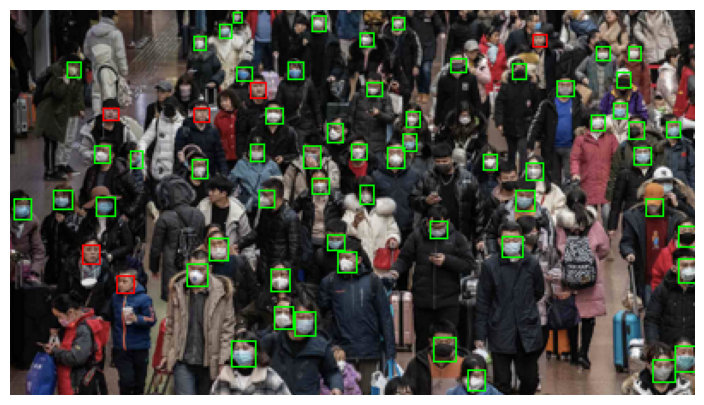

In [201]:
predict_and_draw_boxes(test_dataset)

In [195]:
def dataset_to_coco_json(dataset):
    categories = [
        {
            "id": 0,
            "name": "",
        },
        {
            "id": 1,
            "name": "No Mask"
        },
        {
            "id": 2,
            "name": "Masked"
        }
    ]
    images = []
    annotations = []
    for _, targets in dataset:
        for i in range(len(targets['labels'])):
            annotations.append({
                "id": len(annotations),
                "image_id": len(images),
                "category_id": targets['labels'][i].item(),
                "bbox": targets['boxes'][i].tolist(),
                "area": targets['area'][i].item(),
                "segmentation": [],
                "iscrowd": targets['iscrowd'][i].item()
            })
        images.append({
            "id": len(images),
        })
    return {"categories": categories, "images": images, "annotations": annotations}

In [168]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def predict_and_calc_metrics(test_dataset, nm_threshold=0.5, score_threshold=0.7):
    annotations = dataset_to_coco_json(test_dataset)
    with open('test_annotations.json', 'w') as f:
        json.dump(annotations, f)
    
    predictions = []
    model.eval()

    image_id = 0
    for image, targets in tqdm(test_dataset):
        with torch.no_grad():
            image = image.to(device)
            output = model([image])
        
        boxes, scores, labels = output[0]['boxes'], output[0]['scores'], output[0]['labels']
        keep = nms(boxes, scores, nm_threshold)
        
        boxes = boxes[keep].cpu().numpy()
        scores = scores[keep].cpu().numpy()
        labels = labels[keep].cpu().numpy()
    
        mask = scores > score_threshold
        boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

        for i in range(len(labels)):
            predictions.append({
                "id": len(predictions),
                "image_id": image_id,
                "category_id": labels[i].tolist(),
                "bbox": boxes[i].tolist(),
                "area": ((boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])).item(),
                "segmentation": [],
                "score": scores[i].tolist()
            })
        image_id += 1
    
    with open('test_predictions.json', 'w') as f:
        json.dump(predictions, f)

    coco_gt = COCO("test_annotations.json")
    coco_dt = coco_gt.loadRes("test_predictions.json")
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval

In [203]:
coco_eval = predict_and_calc_metrics(test_dataset, score_threshold=0.0)

100%|██████████| 171/171 [00:21<00:00,  8.11it/s]


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [204]:
print(f"mAP@0.5: {coco_eval.stats[1]}")
print(f"mAP@0.5:0.95: {coco_eval.stats[0]}")
print(f"Precision: {coco_eval.stats[5]}")
print(f"Recall: {coco_eval.stats[11]}")

mAP@0.5: 0.8172210956258421
mAP@0.5:0.95: 0.7472871227642387
Precision: 0.7407044994244809
Recall: 0.865625
